In [2]:
!pip install -q wilds


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
import torch.utils.data as data
import torchvision
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from pathlib import Path
from PIL import Image
import wilds
from wilds.common.data_loaders import get_train_loader, get_eval_loader
device = torch.device('cuda:3')
import train
import copy
import importlib

In [2]:
check_name = Path('models/rxrx1-b3.pt')
task = check_name.stem.split('-')
checkpoint = torch.load(check_name)

In [3]:
dataset = wilds.get_dataset(dataset='rxrx1', root_dir='/u/luchar/data/wilds/')
num_classes = dataset._n_classes
# model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
model = efficientnet_b3()
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model.load_state_dict(checkpoint['model'])
model = model.cuda()

In [4]:
compose_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

id_train_data = dataset.get_subset('train', transform=compose_transforms)
id_test_data = dataset.get_subset('id_test', transform=compose_transforms)
od_val_data = dataset.get_subset('val', transform=compose_transforms)
od_test_data = dataset.get_subset('test', transform=compose_transforms)

In [5]:
subset = lambda ds, indices: data.Subset(ds, indices)
loader = lambda ds: data.DataLoader(ds, batch_size=16, num_workers=8, pin_memory=True, shuffle=False)

cal_split = int(len(id_test_data)*0.1)

id_cal_data = subset(id_test_data, range(cal_split))
id_test_data = subset(id_test_data, range(cal_split, len(id_test_data)))

id_cal_data = subset(id_cal_data, range(min(5000, len(id_cal_data))))
id_test_data = subset(id_test_data, range(min(5000, len(id_test_data))))
od_val_data = subset(od_val_data, range(min(5000, len(od_val_data))))
od_test_data = subset(od_test_data, range(min(5000, len(od_test_data))))
len(id_train_data), len(id_cal_data), len(id_test_data), len(od_val_data), len(od_test_data), len(id_test_data)

(40612, 4061, 5000, 5000, 5000, 5000)

In [6]:
id_cal_scores, id_cal_labels = train.get_scores(model, loader(id_cal_data))
print('cal done')
id_test_scores, id_test_labels = train.get_scores(model, loader(id_test_data))
print('id test done')
od_val_scores, od_val_labels = train.get_scores(model, loader(od_val_data))
print('od val done')
od_test_scores, od_test_labels = train.get_scores(model, loader(od_test_data))
print('od test done')

cal done
id test done
od val done
od test done


In [7]:
train.accuracy(id_test_scores, id_test_labels)
train.accuracy(od_test_scores, od_test_labels)

accuracy: 2.52%
accuracy: 1.60%


0.016

In [8]:
def get_q_hat(calibration_scores, labels, alpha=0.05):
    if not isinstance(calibration_scores, torch.Tensor):
        calibration_scores = torch.tensor(calibration_scores)
       
    n = calibration_scores.shape[0]
   
    #  sort scores and returns values and index that would sort classes
    values, indices = calibration_scores.sort(dim=1, descending=True)
   
    #  sum up all scores cummulatively and return to original index order
    cum_scores = values.cumsum(1).gather(1, indices.argsort(1))[range(n), labels]
   
    #  get quantile with small correction for finite sample sizes
    q_hat = torch.quantile(cum_scores, np.ceil((n + 1) * (1 - alpha)) / n)
    clipped_q_hat = torch.minimum(q_hat, torch.tensor(1-1e-9))
   
    return clipped_q_hat


def make_prediction_set(scores, q_hat):
    if not isinstance(scores, torch.Tensor):
        scores = torch.tensor(scores)
    assert q_hat < 1, 'q_hat must be below 1'
       
    n = scores.shape[0]
   
    values, indices = scores.sort(dim=1, descending=True)
   
    #  number of each confidence prediction set to acheive coverage
    set_sizes = (values.cumsum(1) > q_hat).int().argmax(dim=1)
   
    confidence_sets = [indices[i][0:(set_sizes[i] + 1)] for i in range(n)]
   
    return [x.tolist() for x in confidence_sets]

get_sizes = lambda x: np.array([len(x_i) for x_i in x])

In [9]:
alpha = 0.10
q_hat = get_q_hat(id_cal_scores, id_cal_labels, alpha=alpha)

In [10]:
id_test_pset = make_prediction_set(id_test_scores, q_hat)
od_val_pset = make_prediction_set(od_val_scores, q_hat)
od_test_pset = make_prediction_set(od_test_scores, q_hat)

In [11]:
id_test_size = get_sizes(id_test_pset)
od_val_size = get_sizes(od_val_pset)
od_test_size = get_sizes(od_test_pset)

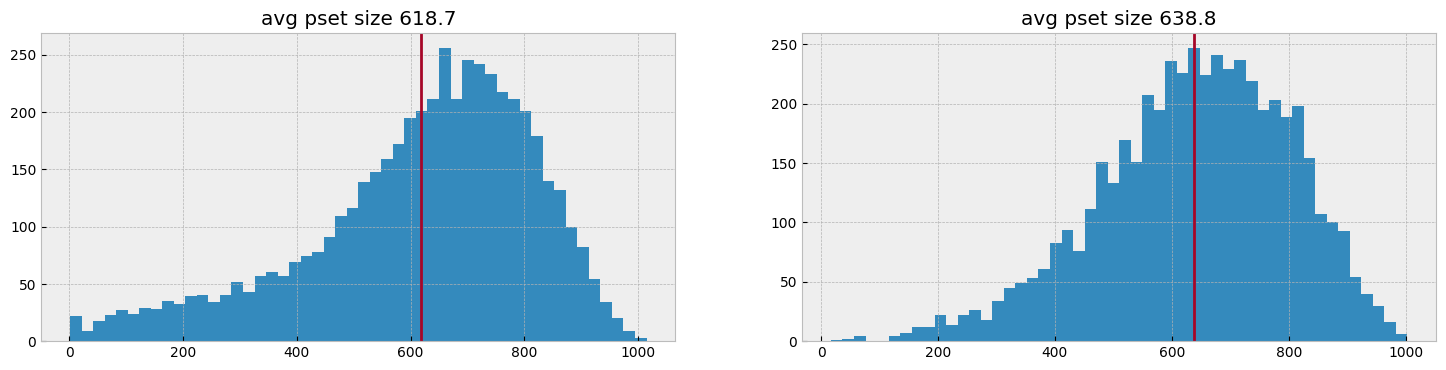

In [12]:
bins=50
fig, ax = plt.subplots(ncols=2, figsize=(18, 4))
ax[0].hist(id_test_size, bins=bins)
ax[1].hist(od_test_size, bins=bins)
ax[0].axvline(id_test_size.mean(), color='C1')
ax[1].axvline(od_test_size.mean(), color='C1')
ax[0].set_title(f'avg pset size {id_test_size.mean():.1f}')
ax[1].set_title(f'avg pset size {od_test_size.mean():.1f}')
plt.show()

In [13]:
budget_per_round = int(0.3 * len(od_val_data))

In [14]:
budget_per_round

1500

In [15]:
np.quantile(id_test_size, 0.30)

549.7

In [16]:
((700 < od_val_size) & (od_val_size < 800)).sum()

553

In [17]:
bought_index = [i for i, size in enumerate(od_test_size) if size > 500]
random_index = np.random.randint(0, len(od_test_size), size=len(bought_index))
len(bought_index), len(random_index)

(4033, 4033)

In [18]:
bought_data = subset(od_test_data, bought_index)
random_data = subset(od_test_data, random_index)

In [19]:
model_bought = copy.deepcopy(model).cuda()
model_random = copy.deepcopy(model).cuda()

criterion = torch.nn.CrossEntropyLoss()
lr = 1e-5
opt_bought = torch.optim.Adam(model_bought.parameters(), lr=lr)
opt_random = torch.optim.Adam(model_random.parameters(), lr=lr)

In [20]:
fit_kwargs = dict(criterion=criterion, epochs=3, debug=False, patience=5)

In [21]:
importlib.reload(train)
model_bought = train.fit(model_bought, loader(bought_data), val_loader=loader(id_test_data), optimizer=opt_bought, **fit_kwargs)
model_random = train.fit(model_random, loader(random_data), val_loader=loader(id_test_data), optimizer=opt_random, **fit_kwargs)


epoch 0
	 0validating... accuracy: 0.68%

epoch 1
	 0validating... accuracy: 0.70%

epoch 2
	 0validating... accuracy: 0.76%

epoch 0
	 0validating... accuracy: 0.92%

epoch 1
	 0validating... accuracy: 0.88%

epoch 2
	 0validating... accuracy: 1.02%


In [22]:
id_bought_scores, id_bought_labels = train.get_scores(model_bought, loader(id_test_data))
id_random_scores, id_random_labels = train.get_scores(model_random, loader(id_test_data))

train.accuracy(id_bought_scores, id_bought_labels)
train.accuracy(id_random_scores, id_random_labels)

In [24]:
od_bought_scores, od_bought_labels = train.get_scores(model_bought, loader(od_test_data))
od_random_scores, od_random_labels = train.get_scores(model_random, loader(od_test_data))

train.accuracy(od_bought_scores, od_bought_labels)
train.accuracy(od_random_scores, od_random_labels)

In [ ]:

def get_entropy(set_sizes, minlength=1):
    n = len(set_sizes)
    counts = np.bincount(set_sizes, minlength=minlength)
    probs = counts / n
    return -sum(p * np.log(p) for p in probs if p != 0)
source_sets_by_alpha = {}
target_sets_by_alpha = {}
for alpha in np.arange(0.1, 1, 0.1):
    alpha = round(alpha, 1)
    q_hat = get_q_hat(source_val_scores, source_val_labels, alpha=alpha)

    source_sets = make_prediction_set(source_val_scores, q_hat)
    target_sets = make_prediction_set(target_train_scores, q_hat)
    source_sets_by_alpha[alpha] = source_sets
    target_sets_by_alpha[alpha] = target_sets
    source_sizes = get_sizes(source_sets)
    target_sizes = get_sizes(target_sets)

    bins = 8
    fig, ax = plt.subplots(ncols=2, figsize=(16, 3))
    ax[0].set_title(f'source: alpha={alpha} entropy={get_entropy(source_sizes)}')
    ax[0].hist(source_sizes, bins=bins)
    ax[0].set_xlim(1, num_classes)
    ax[0].set_xlabel('set size', fontsize=32)
    ax[0].set_ylabel('count', fontsize=32)
    ax[1].set_title(f'target: alpha={alpha} entropy={get_entropy(target_sizes)}')
    ax[1].hist(target_sizes, bins=bins)
    ax[1].set_xlim(1, num_classes)
    ax[1].set_xlabel('set size', fontsize=32)
    ax[1].set_ylabel('count', fontsize=32)
    plt.show()
alpha = 0.1

bought_index = [i for i, x in enumerate(get_sizes(target_sets_by_alpha[alpha])) if x in range(30, 60)]
num_bought = len(bought_index)
print(f'bought {num_bought / len(target_sets_by_alpha[alpha]):.0%} samples out of {len(target_sets_by_alpha[alpha])}')
bought_train = target_train_df.iloc[bought_index]
print(f'labeled {len(bought_train)} samples')

bought_df = pd.concat([source_train_df, bought_train])
bought_loader = loader(Dataset(bought_df), **loader_kwargs)
print(f'number in new bought training set {len(bought_df)}')
random_df = pd.concat([source_train_df, target_train_df.sample(n=len(bought_train))])
random_loader = loader(Dataset(random_df), **loader_kwargs)
print(f'number in new training set {len(bought_loader)}')
print(f'number in new random training set {len(random_df)}')
import copy
model1 = copy.deepcopy(model)
model2 = copy.deepcopy(model)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-4)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4)

model1 = fit(model1, bought_loader, criterion, optimizer1)
model2 = fit(model2, random_loader, criterion, optimizer2)
source_test_scores1, source_test_labels1 = get_scores(model1, source_test)
source_test_scores2, source_test_labels2 = get_scores(model2, source_test)
target_test_scores1, target_test_labels1 = get_scores(model1, target_test)
target_test_scores2, target_test_labels2 = get_scores(model2, target_test)
print(metrics.accuracy_score(source_test_scores1.argmax(1), source_test_labels1))
print(metrics.accuracy_score(source_test_scores2.argmax(1), source_test_labels2))
print(metrics.accuracy_score(target_test_scores1.argmax(1), target_test_labels1))
print(metrics.accuracy_score(target_test_scores2.argmax(1), target_test_labels2))